In [241]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from model import FeatureDependentMarkovChain
from sklearn.preprocessing import QuantileTransformer

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


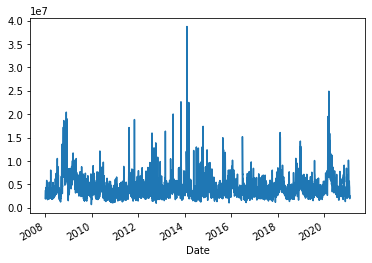

In [291]:
df = yf.download("IVV")
df["RET"] = df["Adj Close"].pct_change()
df["RET5D"] = df.RET.shift(1).rolling(5).mean()
df["RET20D"] = df.RET.shift(1).rolling(20).mean()
df["RET60D"] = df.RET.shift(1).rolling(60).mean()
vix = yf.download("^VIX")["Adj Close"].shift(1)
df["VIX"] = vix[df.index]
df = df[df.index >= "2008"]
df.Volume.plot()

In [316]:
bins = 5
x = pd.qcut(df["Volume"], q=bins).cat.codes
P = np.zeros((bins, bins))
for i in range(x.shape[0] - 1):
    P[x[i], x[i+1]] += 1
P /= P.sum(axis=1)[:,None]
np.round(P, 2)

array([[0.42, 0.24, 0.18, 0.11, 0.04],
       [0.26, 0.28, 0.21, 0.16, 0.08],
       [0.18, 0.26, 0.23, 0.22, 0.11],
       [0.09, 0.14, 0.24, 0.29, 0.24],
       [0.04, 0.07, 0.14, 0.22, 0.53]])

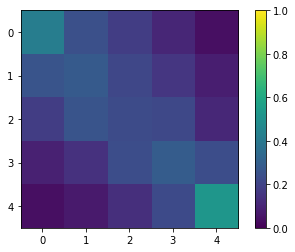

In [314]:
plt.imshow(P, vmin=0, vmax=1)
plt.colorbar()

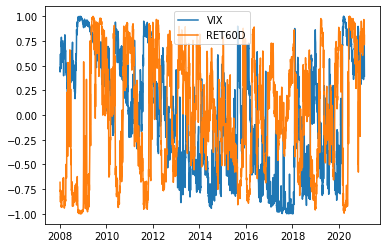

In [320]:
states = list(x)
features = df[["VIX", "RET60D"]].values
scaler = QuantileTransformer()
features = (scaler.fit_transform(features) - .5) * 2
plt.plot(df.index, features[:,0], label='VIX')
plt.plot(df.index, features[:,1], label='RET60D')
plt.legend()

In [321]:
for idx in np.random.choice(np.arange(1, len(states) - 1001), 500, replace=False):
    states[idx] = np.nan

In [322]:
model = FeatureDependentMarkovChain(bins, lam=0)
model.fit(states[:-1000], features[:-1000]* 0, [len(states[:-1000])])
model.score(states[:-1000], features[:-1000] * 0, [len(states[:-1000])]), model.score(states[-1000:], features[-1000:] * 0, [len(states[-1000:])])

(-2032.6650662215795, -1467.1926813418427)

In [323]:
model = FeatureDependentMarkovChain(bins, lam=10, n_iter=1)
model.fit(states[:-1000], features[:-1000], [len(states[:-1000])], verbose=True)
model.score(states[:-1000], features[:-1000], [len(states[:-1000])]), model.score(states[-1000:], features[-1000:], [len(states[-1000:])])

(-1981.7233517059994, -1445.7724345161112)

In [324]:
model = FeatureDependentMarkovChain(bins, lam=10, n_iter=10)
model.fit(states[:-1000], features[:-1000], [len(states[:-1000])], verbose=True)
model.score(states[:-1000], features[:-1000], [len(states[:-1000])]), model.score(states[-1000:], features[-1000:], [len(states[-1000:])])

1 -2615.639011009975
2 -2615.086304660476
3 -2615.0313678194625
4 -2615.023586834328


(-1983.626280414951, -1441.9073503312788)

Varying VIX


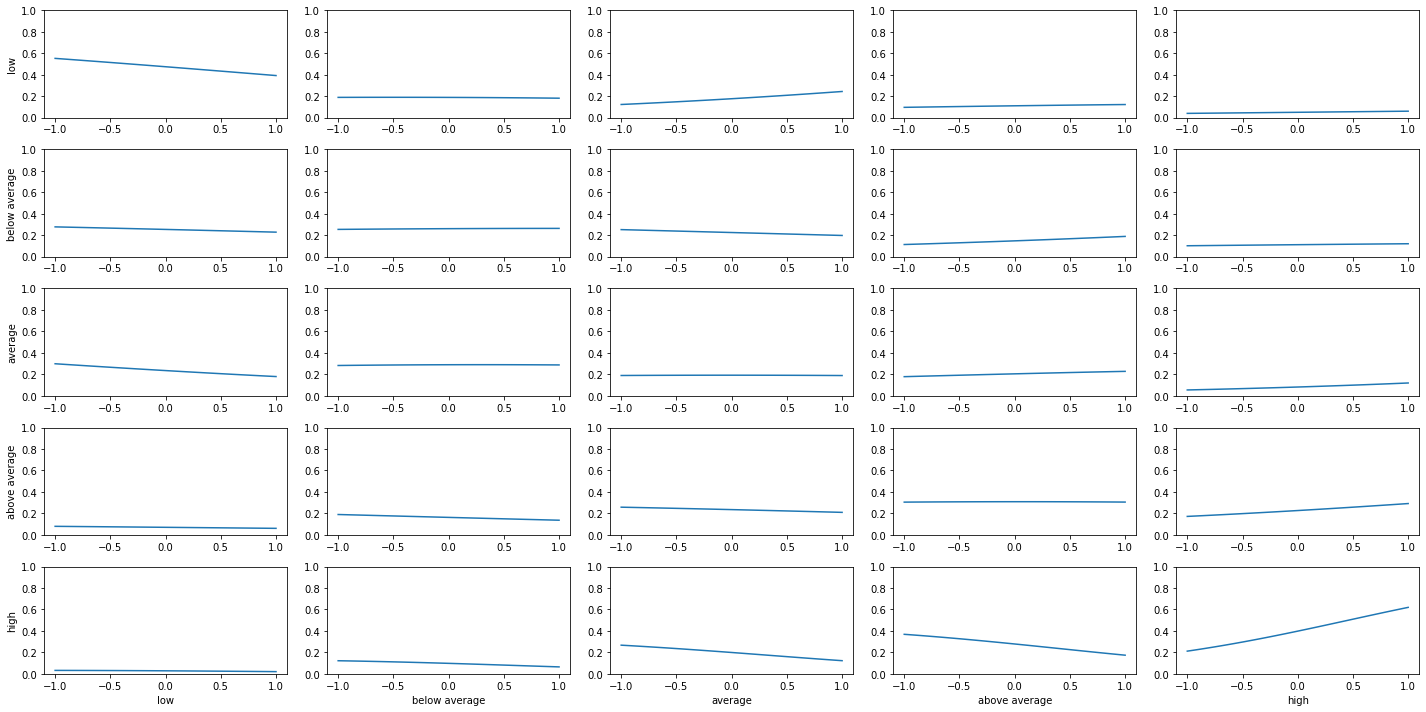

In [306]:
features_fake = np.zeros((100, 2))
features_fake[:, 0] = np.linspace(-1, 1, 100)
Ps = model.predict(features_fake)

fig, axes = plt.subplots(bins, bins, figsize=(20, 10))
for i in range(bins):
    for j in range(bins):
        axes[i, j].plot(features_fake[:, 0], Ps[:,i,j])
        axes[i, j].set_ylim(0, 1)
for i, c in enumerate(["low", "below average", "average", "above average", "high"]):
    axes[i, 0].set_ylabel(c)
    axes[-1, i].set_xlabel(c)
plt.tight_layout()
print("Varying VIX")
plt.show()

Varying RET60D


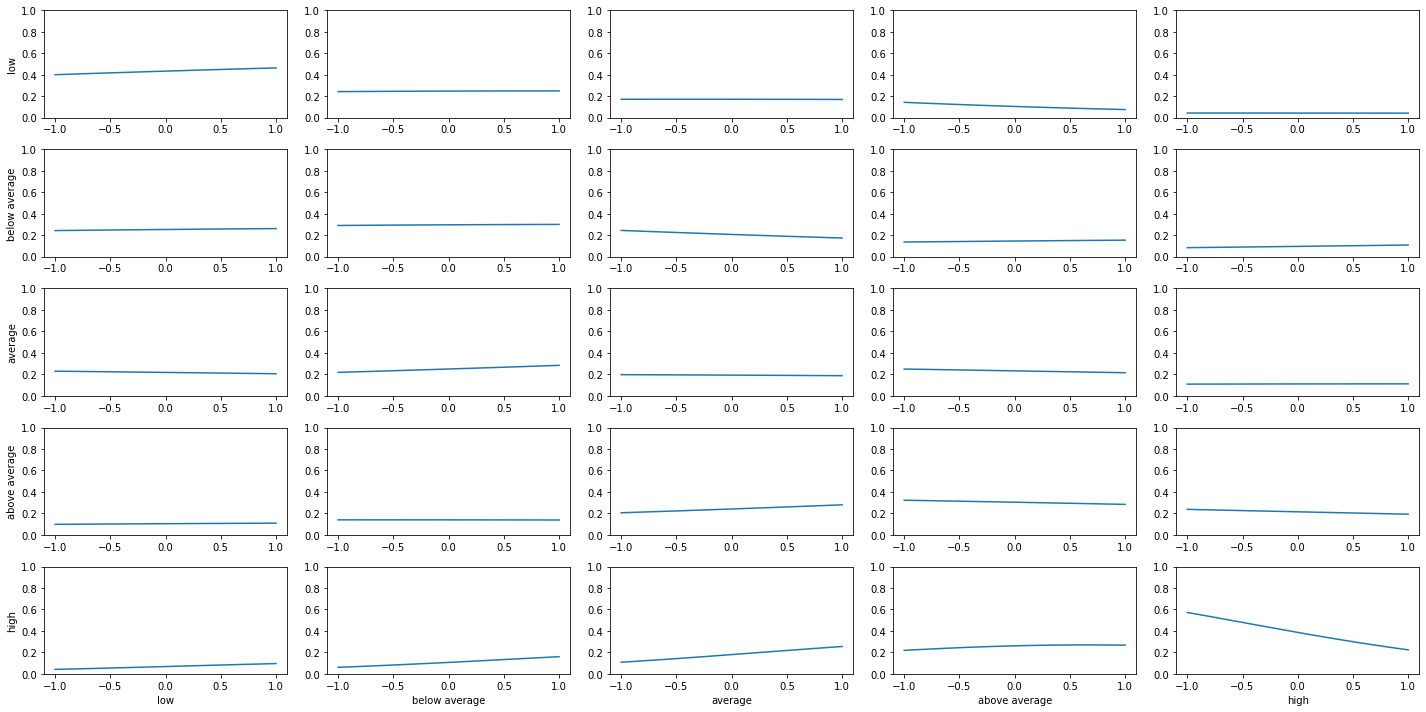

In [301]:
features_fake = np.zeros((100, 2))
features_fake[:, 1] = np.linspace(-1, 1, 100)
Ps = model.predict(features_fake)

fig, axes = plt.subplots(bins, bins, figsize=(20, 10))
for i in range(bins):
    for j in range(bins):
        axes[i, j].plot(features_fake[:, 1], Ps[:,i,j])
        axes[i, j].set_ylim(0, 1)

for i, c in enumerate(["low", "below average", "average", "above average", "high"]):
    axes[i, 0].set_ylabel(c)
    axes[-1, i].set_xlabel(c)
plt.tight_layout()
print("Varying RET60D")
plt.show()